<a href="https://colab.research.google.com/github/Joes24/Electivo2_Proyectofinal-Anteproyecto-/blob/main/Electivo2_ProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Electivo II – Métodos numéricos

## Proyecto Final (Anteproyecto)

## Integrantes: José Gormaz, Octavio Marchant, Miguel Quispe, Steffany Urzúa.

## Super-resolución de Imagenes 2D
## mediante Metodos Numéricos e Integración Web con Flask

In [22]:
import os

# 1. Instalamos de librerías necesarias
!pip install flask numpy scipy pillow matplotlib pyngrok

# 2. Estructura de directorios

# Carpeta principal para el módulo numérico
os.makedirs('superres', exist_ok=True)

# Archivo de inicialización del paquete
!touch superres/__init__.py

# Carpeta para plantillas HTML (para Flask)
os.makedirs('templates', exist_ok=True)

# Carpeta para recursos estáticos y resultados (para Flask)
os.makedirs('static/results', exist_ok=True)

In [23]:
#superres/operadores.py (Operador A y A^T)

%%writefile superres/operadores.py
import numpy as np
from scipy.ndimage import convolve

class BlurDownsampleOperator:
    """
    Implementamos el operador lineal A que degrada la imagen HR mediante:
    1. Desenfoque gaussiano 2D (convolución G*x)[cite: 105, 46].
    2. Submuestreo (downsampling) por un factor entero s[cite: 108].

    También implementamos el adjunto A^T[cite: 110].
    """
    def __init__(self, kernel_size, sigma, s):
        self.s = s  # Factor de submuestreo
        self.kernel = self._gaussian_kernel(kernel_size, sigma)

    def _gaussian_kernel(self, size, sigma):
        """Genera un kernel Gaussiano 2D[cite: 104]."""
        ax = np.arange(-size // 2 + 1., size // 2 + 1.)
        xx, yy = np.meshgrid(ax, ax)

        # Fórmula de la Gaussiana
        kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))

        # Normalizamos
        return kernel / np.sum(kernel)

    def forward(self, x):
        """
        Calculamos Ax = (G * x) ↓s (Degradación).
        x: Imagen de Alta Resolución (HR)
        """
        # 1. Convolución (Blur Gaussiano)
        # Usamos mode='wrap' para la convolución circular [cite: 107]
        blurred = convolve(x, self.kernel, mode='wrap')

        # 2. Submuestreo: tomar un píxel cada 's'
        downsampled = blurred[::self.s, ::self.s]

        return downsampled

    def adjoint(self, y):
        """
        Calculamos A^T y = G^T * (upsample(y))[cite: 110].
        y: Imagen de Baja Resolución (LR) observada (b).
        """
        H_lr, W_lr = y.shape
        # Calculamos dimensiones HR
        H_hr, W_hr = H_lr * self.s, W_lr * self.s

        # 1. Upsample (Insertar ceros) [cite: 112]
        y_upsampled = np.zeros((H_hr, W_hr))
        y_upsampled[::self.s, ::self.s] = y

        # 2. Convolución con el Kernel Adjunto (G^T)
        # G es simétrico, G^T = G.
        x_recon = convolve(y_upsampled, self.kernel, mode='wrap')

        return x_recon

Overwriting superres/operadores.py


In [24]:
#superres/regularizadores.py (L2 y Huber)

%%writefile superres/regularizadores.py
import numpy as np

#Clases Base

class Regularizer:
    """Clase base para regularizadores. Define la interfaz de valor y gradiente."""
    def value(self, x):
        """Calcula el valor de la función de regularización R(x)."""
        raise NotImplementedError
    def gradient(self, x):
        """Calcula el gradiente de la función de regularización nabla R(x)."""
        raise NotImplementedError

#Funciones Auxiliares (Diferencias Finitas)

def get_grads(x):
    """
    Calcula los gradientes discretos horizontal (Dx) y vertical (Dy).
    Usa diferencias finitas hacia adelante (como D_x x_{i,j} = x_{i, j+1} - x_{i,j}).
    """
    # Dx: x[i, j+1] - x[i, j]
    Dx = np.roll(x, -1, axis=1) - x
    Dx[:, -1] = 0.0 # Condición de borde de Neumann o ajuste para ser adjunto exacto

    # Dy: x[i+1, j] - x[i, j]
    Dy = np.roll(x, -1, axis=0) - x
    Dy[-1, :] = 0.0 # Condición de borde de Neumann o ajuste
    return Dx, Dy

def get_divergence(Px, Py):
    """
    Calcula la divergencia discreta de un campo vectorial (Px, Py), que es
    el adjunto negativo del gradiente[cite: 40].
    """
    # Divergencia horizontal (diferencias hacia atrás)
    Px_pad = np.pad(Px, ((0, 0), (1, 0)), mode='constant')
    div_x = Px_pad[:, 1:] - Px_pad[:, :-1]
    div_x[:, 0] = Px[:, 0]
    div_x[:, -1] = -Px[:, -2]

    # Divergencia vertical (diferencias hacia atrás)
    Py_pad = np.pad(Py, ((1, 0), (0, 0)), mode='constant')
    div_y = Py_pad[1:, :] - Py_pad[:-1, :]
    div_y[0, :] = Py[0, :]
    div_y[-1, :] = -Py[-2, :]

    return div_x + div_y

#Implementación de Regularizadores

class L2GradientRegularizer(Regularizer):
    """
    Regularización L2 del gradiente: R_L2(x) = ||Dx||^2 + ||Dy||^2[cite: 36].
    Su gradiente es -2 * Laplaciano(x)[cite: 39].
    """
    def value(self, x):
        Dx, Dy = get_grads(x)
        return np.sum(Dx**2 + Dy**2)

    def gradient(self, x):
        # Gradiente: nabla R_L2(x) = -2 * div(Dx, Dy) = -2 * Laplaciano [cite: 39]
        Dx, Dy = get_grads(x)
        laplacian = get_divergence(Dx, Dy)
        return -2 * laplacian

class HuberGradientRegularizer(Regularizer):
    """
    Regularización Huber (Huber-TV).
    Usa la función de Huber para suavizar los términos de gradiente [cite: 41-44].
    """
    def __init__(self, delta=0.01):
        self.delta = delta # Parámetro delta (debe ser configurable) [cite: 42]

    def _huber_prime(self, z):
        """
        Derivada de la función de Huber phi'(z)[cite: 46].
        Si |z| <= delta: z/delta
        Si |z| > delta: sign(z)
        """
        condition = np.abs(z) <= self.delta
        return np.where(condition, z / self.delta, np.sign(z))

    def value(self, x):
        """Valor R_Huber(x) para monitoreo (opcional, no crítico para el gradiente)."""
        # (Implementación simplificada para valor, enfocando en gradiente)
        Dx, Dy = get_grads(x)
        # Calcula el valor de phi_delta para cada componente
        R_x = np.where(np.abs(Dx) <= self.delta, 0.5 * Dx**2 / self.delta, np.abs(Dx) - self.delta / 2)
        R_y = np.where(np.abs(Dy) <= self.delta, 0.5 * Dy**2 / self.delta, np.abs(Dy) - self.delta / 2)
        return np.sum(R_x + R_y)

    def gradient(self, x):
        """
        Gradiente de Huber: - div( phi'(Dx), phi'(Dy) )[cite: 52].
        """
        Dx, Dy = get_grads(x)

        # Aplicar phi' a cada componente del gradiente
        W_x = self._huber_prime(Dx)
        W_y = self._huber_prime(Dy)

        # Calcular divergencia de los gradientes ponderados
        return -get_divergence(W_x, W_y)

Overwriting superres/regularizadores.py


In [25]:
#superres/utils.py (Utilidades de Imagen)

%%writefile superres/utils.py
import numpy as np
from PIL import Image
import os

def load_image(filepath):
    """
    Carga una imagen (PNG/JPG), la convierte a escala de grises y la normaliza a [0, 1].
    Esto es crucial para que el algoritmo numérico trabaje con valores estándar.
    """
    try:
        # Abrir imagen, convertir a escala de grises ('L')
        img = Image.open(filepath).convert('L')
    except FileNotFoundError:
        print(f"Error: Archivo no encontrado en {filepath}")
        return None

    # Convertir a matriz numpy de punto flotante
    img_array = np.array(img, dtype=np.float32)

    # Normalizar al rango [0, 1]
    return img_array / 255.0

def save_image(img_array, filepath):
    """
    Convierte una matriz numpy normalizada [0, 1] a una imagen (PNG por defecto) y la guarda.
    """
    # Asegurar que los valores estén en el rango [0, 1] antes de escalar
    img_array = np.clip(img_array, 0.0, 1.0)

    # Convertir a 0-255 entero (uint8)
    img_uint8 = (img_array * 255).astype(np.uint8)

    # Crear y guardar la imagen usando Pillow
    img = Image.fromarray(img_uint8)
    img.save(filepath)

Overwriting superres/utils.py


In [26]:
#superres/gd.py (Descenso de Gradiente)

%%writefile superres/gd.py
import numpy as np
# Importamos las clases definidas para lo anterior
from superres.operadores import BlurDownsampleOperator
from superres.regularizadores import Regularizer

class GDSolver:
    """
    Implementa el método de Descenso de Gradiente (Gradient Descent, GD)
    para resolver el problema de Super-Resolución (SR).

    Minimiza la función de costo J(x) = 0.5 ||Ax - b||^2 + lambda * R(x).
    """
    def __init__(self, operator: BlurDownsampleOperator, regularizer: Regularizer, learning_rate: float, lambda_reg: float):
        self.A = operator          # Operador A y A^T
        self.reg = regularizer     # Regularizador R(x) (L2 o Huber)
        self.tau = learning_rate   # Paso de descenso (tau > 0) [cite: 93]
        self.lam = lambda_reg      # Peso de regularización (lambda > 0) [cite: 60]
        self.loss_history = []     # Para monitorear la convergencia

    def _calculate_cost(self, x, residual):
        """Calcula el valor de la función de costo J(x) para monitoreo."""
        fid_cost = 0.5 * np.sum(residual**2) # Término de Fidelidad (data fidelity)
        reg_cost = self.reg.value(x)          # Término de Regularización
        return fid_cost + self.lam * reg_cost

    def solve(self, b: np.ndarray, iterations: int):
        """
        Ejecuta las iteraciones del descenso de gradiente.
        b: Imagen de baja resolución observada (LR).
        """
        self.loss_history = []

        # 1. Inicialización: x^(0) = upsample(b) [cite: 85]
        # Usamos A^T (adjoint), que incluye el upsample + convolución G^T
        x = self.A.adjoint(b)

        # 2. Bucle de iteraciones [cite: 90]
        for k in range(iterations):
            # --- Paso A: Gradiente de Fidelidad ---
            # grad_fid = A^T * (Ax - b)
            Ax = self.A.forward(x)
            residual = Ax - b
            grad_fidelity = self.A.adjoint(residual) # A^T(residual)

            #Paso B: Gradiente de Regularización
            # grad_reg = lambda * nabla R(x)
            grad_reg = self.reg.gradient(x)

            #Paso C: Actualización (Descenso)
            # x_new = x - tau * (grad_fidelity + lambda * grad_reg)
            # Implementación de la fórmula: x^(k+1) = x^(k) - tau * [ A^T(Ax - b) + lambda * nabla R(x) ] [cite: 92]
            total_grad = grad_fidelity + self.lam * grad_reg
            x = x - self.tau * total_grad

            # Monitoreo: Calcular costo cada 10 iteraciones
            if k % 10 == 0:
                total_cost = self._calculate_cost(x, residual)
                self.loss_history.append(total_cost)

        return x

Overwriting superres/gd.py


Iniciando Demostración Numérica (Anteproyecto)
Dimensiones HR: (128, 128), Dimensiones LR (Input b): (32, 32)
Ejecutando Descenso de Gradiente (200 iteraciones)...
Reconstrucción finalizada.


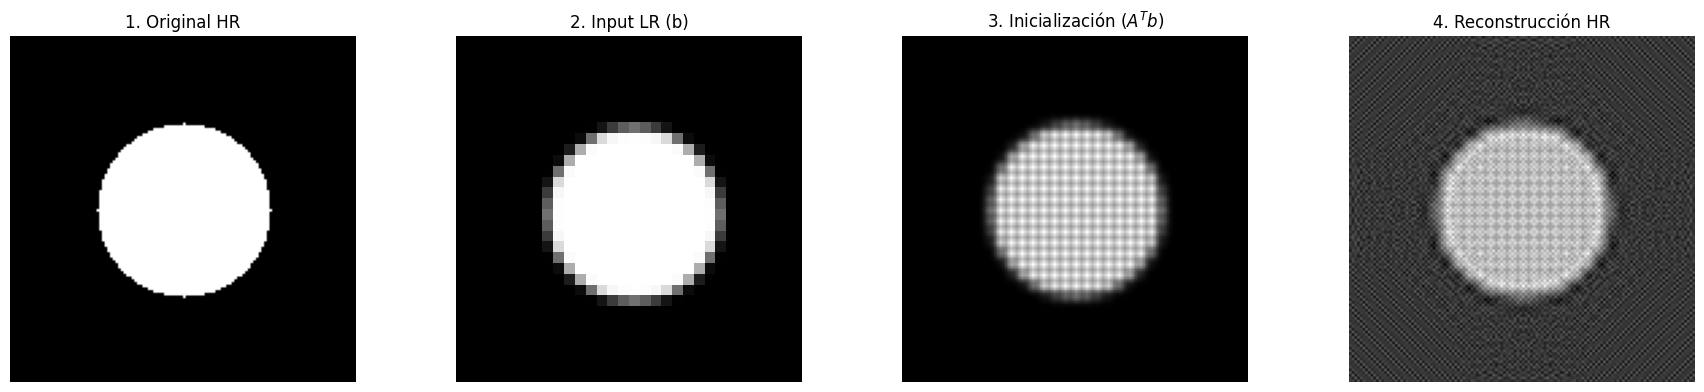

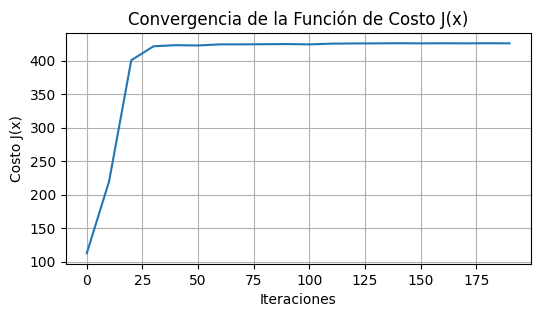

In [27]:
import numpy as np
import matplotlib.pyplot as plt
# Importamos las clases que ya hemos definido
from superres.operadores import BlurDownsampleOperator
from superres.regularizadores import L2GradientRegularizer, HuberGradientRegularizer
from superres.gd import GDSolver
from superres.utils import save_image # Para guardar resultados en caso de ser necesario

def create_synthetic_image(N):
    """Esto crea una imagen de prueba HR (círculo blanco) de N x N."""
    y, x = np.ogrid[:N, :N]
    center = (N//2, N//2)
    mask = (x - center[1])**2 + (y - center[0])**2 <= (N//4)**2
    img_hr = np.zeros((N, N))
    img_hr[mask] = 1.0
    return img_hr

def run_demo():
    """Ejecuta el pipeline completo de Super-Resolución (HR -> LR -> HR)."""
    print("Iniciando Demostración Numérica (Anteproyecto)")

    # 1. Parámetros del experimento
    N_HR = 128             # Tamaño de la imagen de Alta Resolución (HR)
    s_factor = 4           # Factor de submuestreo (LR será 32x32)

    # Parámetros del Solver (optimizado para este ejemplo)
    iters = 200
    tau = 1.5              # Learning Rate (tau)
    lam = 0.05             # Peso de Regularización (lambda)

    # 2. Generar y degradar la imagen
    img_hr = create_synthetic_image(N_HR)
    operator = BlurDownsampleOperator(kernel_size=9, sigma=1.5, s=s_factor)
    img_lr = operator.forward(img_hr) # La imagen de baja resolución (b)

    print(f"Dimensiones HR: {img_hr.shape}, Dimensiones LR (Input b): {img_lr.shape}")

    # 3. Configurar el Solver (usamos Huber por defecto)
    reg = HuberGradientRegularizer(delta=0.01) # Se podría probar L2: L2GradientRegularizer()
    solver = GDSolver(operator, reg, learning_rate=tau, lambda_reg=lam)

    # 4. Resolver
    print(f"Ejecutando Descenso de Gradiente ({iters} iteraciones)...")
    img_recon = solver.solve(img_lr, iterations=iters)
    print("Reconstrucción finalizada.")

    # 5. Visualizar Resultados
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))

    titles = ["1. Original HR", "2. Input LR (b)", "3. Inicialización ($A^T b$)", "4. Reconstrucción HR"]
    images = [img_hr, img_lr, operator.adjoint(img_lr), img_recon]

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    # 6. Gráfico de Convergencia (Prueba de funcionamiento)
    plt.figure(figsize=(6, 3))
    plt.plot(np.arange(len(solver.loss_history)) * 10, solver.loss_history)
    plt.title("Convergencia de la Función de Costo J(x)")
    plt.xlabel("Iteraciones")
    plt.ylabel("Costo J(x)")
    plt.grid(True)
    plt.show()

    # save_image(img_recon, 'static/results/demo_recon.png')

# Ejecutamos la demo
run_demo()

In [28]:
#requirements.txt

%%writefile requirements.txt
flask
numpy
scipy
pillow
matplotlib
pyngrok

Overwriting requirements.txt


In [29]:
#demo_parcial.py (en la raíz)

%%writefile demo_parcial.py
import numpy as np
import matplotlib.pyplot as plt
from superres.operators import BlurDownsampleOperator
from superres.regularizers import L2GradientRegularizer, HuberGradientRegularizer
from superres.gd import GDSolver
from superres.utils import save_image

def create_synthetic_image(N):
    """Crea una imagen de prueba HR (círculo blanco) de N x N."""
    y, x = np.ogrid[:N, :N]
    center = (N//2, N//2)
    mask = (x - center[1])**2 + (y - center[0])**2 <= (N//4)**2
    img_hr = np.zeros((N, N))
    img_hr[mask] = 1.0
    return img_hr

def run_demo():
    """Ejecuta el pipeline completo de Super-Resolución (HR -> LR -> HR)."""
    print("Iniciando Demostración Numérica (Anteproyecto)")

    # 1. Parámetros del experimento
    N_HR = 128
    s_factor = 4
    iters = 200
    tau = 1.5
    lam = 0.05

    # 2. Generar y degradar la imagen
    img_hr = create_synthetic_image(N_HR)
    operator = BlurDownsampleOperator(kernel_size=9, sigma=1.5, s=s_factor)
    img_lr = operator.forward(img_hr)

    print(f"Dimensiones HR: {img_hr.shape}, Dimensiones LR (Input b): {img_lr.shape}")

    # 3. Configurar el Solver (Huber)
    reg = HuberGradientRegularizer(delta=0.01)
    solver = GDSolver(operator, reg, learning_rate=tau, lambda_reg=lam)

    # 4. Resolver
    print(f"Ejecutando Descenso de Gradiente ({iters} iteraciones)...")
    img_recon = solver.solve(img_lr, iterations=iters)
    print("Reconstrucción finalizada.")

    # 5. Visualizar Resultados (Imágenes)
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    titles = ["1. Original HR", "2. Input LR (b)", "3. Inicialización ($A^T b$)", "4. Reconstrucción HR"]
    images = [img_hr, img_lr, operator.adjoint(img_lr), img_recon]

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    # 6. Gráfico de Convergencia (Prueba de funcionamiento)
    plt.figure(figsize=(6, 3))
    plt.plot(np.arange(len(solver.loss_history)) * 10, solver.loss_history)
    plt.title("Convergencia de la Función de Costo J(x)")
    plt.xlabel("Iteraciones")
    plt.ylabel("Costo J(x)")
    plt.grid(True)
    plt.show()

# Ejecutamos la demo
run_demo()

print("Archivo demo_parcial.py creado en la raíz.")

Overwriting demo_parcial.py


In [30]:
#README.md (Documentación)

%%writefile README.md
#Proyecto Final: Super-Resolución de Imágenes 2D

##Entrega Parcial (Anteproyecto): Método Numérico Funcional

##Integrantes: José Gormaz, Octavio Marchant, Miguel Quispe, Steffany Urzúa.

Este repositorio contiene la implementación del método de **Descenso de Gradiente (GD)** para resolver un problema de Super-Resolución (SR) de imágenes, formulado como un problema inverso regularizado.


## 1. Formulación Matemática del Problema

El objetivo es encontrar la imagen de alta resolución $x$ que minimice la siguiente función de costo $J(x)$:

$$\min_{x}J(x)=\frac{1}{2}||Ax-b||^{2}+\lambda R(x)$$

* $||Ax-b||^{2}$: **Término de fidelidad** (Error cuadrático).
* $R(x)$: **Término de regularización** (Penaliza la falta de suavidad).
* $A$: **Operador de Degradación** (Desenfoque Gaussiano + Submuestreo).


## 2. Regularizadores Implementados

Los regularizadores operan sobre el gradiente de la imagen para imponer estabilidad:

### A. Regularización L2 del Gradiente (Tikhonov)
* **Clase:** `L2GradientRegularizer`
* **Gradiente ($\nabla R(x)$):** Proporcional al **Laplaciano** de la imagen.

### B. Regularización Huber del Gradiente (TV Suavizada)
* **Clase:** `HuberGradientRegularizer`
* **Ventaja:** Utiliza la función de Huber ($\phi_{\delta}$) para preservar bordes mejor que L2, ya que no penaliza gradientes grandes (bordes) tan severamente.


## 3. Estructura del Repositorio y Ejecución

### A. Estructura de Archivos

| Archivo / Carpeta | Propósito |
| :--- | :--- |
| `demo_parcial.py` | Script ejecutable para demostrar el método numérico. |
| `requirements.txt` | Lista de dependencias. |
| `superres/` | Módulo Python con todas las clases de optimización. |

### B. Instalación

1.  Clonar el repositorio.
2.  Crear un entorno virtual (opcional pero recomendado).
3.  Instalar las dependencias necesarias:
    ```bash
    pip install -r requirements.txt
    ```

### C. Ejecución de la Demo Numérica

Ejecute el script de prueba para generar la reconstrucción de la imagen sintética y el gráfico de convergencia:
```bash
python demo_parcial.py

Overwriting README.md
